# Multimodal Alignment: Towards the Platonic Representation

This notebook implements a framework for aligning pre-trained unimodal encoders (ResNet-18 for images, DistilBERT for text) into a shared multimodal latent space using lightweight adapters. The goal is to test whether such aligned representations better approximate those of larger, more performant models like DINOv2, providing empirical evidence for the Platonic Representation Hypothesis.

## Key Components:
- **Frozen Encoders**: ResNet-18 (ImageNet) and DistilBERT (BookCorpus)
- **Adapters**: Linear and MLP transformations to shared latent space
- **Training**: Dual-encoder contrastive learning on Flickr30k image-caption pairs
- **Evaluation**: Kernel alignment metrics, similarity analysis, and downstream CIFAR-10 evaluation


## Setup and Configuration


In [ ]:
# Install required packages
%pip install -q torch torchvision transformers pillow tqdm numpy scikit-learn matplotlib seaborn datasets wandb


In [24]:
# Core imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from transformers import DistilBertModel, DistilBertTokenizer, Dinov2Model
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Optional imports with fallbacks
try:
    import wandb
    WANDB_AVAILABLE = True
except ImportError:
    WANDB_AVAILABLE = False
    print("W&B not available, using local logging only")

try:
    from datasets import load_dataset
    DATASETS_AVAILABLE = True
except ImportError:
    DATASETS_AVAILABLE = False
    print("datasets library not available")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")


PyTorch version: 2.9.0
CUDA available: False
Device: cpu


## Understanding Multimodal Alignment

### What is Multimodal Alignment?

Multimodal alignment is the process of learning a shared representation space where different modalities (like images and text) can be compared and related to each other. Think of it like learning a universal language that both images and text can "speak" - once they're in this shared space, we can measure how similar an image and its caption are.

### Why Use Contrastive Learning?

Contrastive learning is a powerful technique that teaches models by showing them what should be similar and what should be different:

- **Positive pairs**: An image and its correct caption should be similar in the shared space
- **Negative pairs**: An image and a random caption should be far apart in the shared space

This is like teaching someone to recognize that "a dog running in the park" should be close to a photo of a dog running, but far from a photo of a cat sleeping.

### The Platonic Representation Hypothesis

This is a fascinating theoretical idea that suggests all good models, regardless of how they're trained, converge to similar internal representations of the world. It's named after Plato's idea of "ideal forms" - the notion that there's a perfect, abstract representation of everything that exists.

In our context, we're testing whether:
1. Different unimodal models (ResNet for images, DistilBERT for text) can be aligned into a shared space
2. This aligned space approximates the representations of larger, more powerful multimodal models
3. This provides evidence for the "Platonic" nature of learned representations


In [25]:
# Configuration and setup
class Config:
    def __init__(self, **kwargs):
        # Core settings
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.seed = 42
        
        # Data settings
        self.num_samples = 2000  # Reduced for faster experimentation
        self.batch_size = 32 if not torch.cuda.is_available() else 64
        self.img_size = 224
        
        # Model settings
        self.embed_dim = 768  # Shared embedding dimension (same as CLIP)
        self.img_dim = 512    # ResNet-18 output
        self.text_dim = 768   # DistilBERT output
        
        # Training settings
        self.epochs = 1
        self.lr = 1e-4
        self.temperature = 0.07
        self.weight_decay = 1e-4
        self.grad_clip_norm = 1.0
        
        # Evaluation settings
        self.eval_frequency = 2
        self.viz_frequency = 2
        
        # Paths
        self.save_dir = Path('./results')
        self.save_dir.mkdir(exist_ok=True)
        
        # Optional features
        self.use_wandb = False  # Set to True if you want W&B logging
        self.use_mixed_precision = torch.cuda.is_available()
        
        # Update with any provided kwargs
        for key, value in kwargs.items():
            setattr(self, key, value)
    
    def to_dict(self):
        return {k: v for k, v in self.__dict__.items() 
                if not isinstance(v, (torch.device, Path))}

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Initialize config
config = Config()
print("Configuration:")
for k, v in config.to_dict().items():
    print(f"  {k}: {v}")


Configuration:
  seed: 42
  num_samples: 2000
  batch_size: 32
  img_size: 224
  embed_dim: 768
  img_dim: 512
  text_dim: 768
  epochs: 1
  lr: 0.0001
  temperature: 0.07
  weight_decay: 0.0001
  grad_clip_norm: 1.0
  eval_frequency: 2
  viz_frequency: 2
  use_wandb: False
  use_mixed_precision: False


In [26]:
# Robust dataset loading with retries and fallbacks
import time
import random

def load_flickr30k_with_retry(max_samples=None, max_retries=3):
    """Load Flickr30k dataset with retry logic and fallback options."""
    if not DATASETS_AVAILABLE:
        print("datasets library not available, creating fallback dataset...")
        return create_fallback_dataset(max_samples)
    
    for attempt in range(max_retries):
        try:
            print(f"Attempting to load Flickr30k dataset (attempt {attempt + 1}/{max_retries})...")
            
            # Explicitly set token to None to avoid auth issues
            dataset = load_dataset("nlphuji/flickr30k", split='test', token=None)
            
            if max_samples:
                dataset = dataset.select(range(min(max_samples, len(dataset))))
            
            print(f"Successfully loaded {len(dataset)} samples from Flickr30k")
            return dataset
            
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {str(e)}")
            if attempt < max_retries - 1:
                wait_time = 2 ** attempt  # Exponential backoff
                print(f"Waiting {wait_time} seconds before retry...")
                time.sleep(wait_time)
            else:
                print("All attempts failed, falling back to synthetic dataset...")
                return create_fallback_dataset(max_samples)

def create_fallback_dataset(max_samples=None):
    """Create a small synthetic dataset for testing when Flickr30k is unavailable."""
    print("Creating fallback synthetic dataset...")
    
    # Create synthetic image-caption pairs
    captions = [
        "A dog running in the park",
        "A cat sitting on a chair", 
        "A car driving on the road",
        "A person walking on the street",
        "A bird flying in the sky",
        "A flower blooming in the garden",
        "A house with a red roof",
        "A tree with green leaves",
        "A boat sailing on water",
        "A mountain covered in snow"
    ]
    
    # Extend captions to reach desired size
    if max_samples:
        while len(captions) < max_samples:
            captions.extend(captions[:min(10, max_samples - len(captions))])
        captions = captions[:max_samples]
    
    # Create synthetic dataset structure
    class SyntheticDataset:
        def __init__(self, captions):
            self.captions = captions
            self.images = [None] * len(captions)  # Will be replaced with actual images
            
        def __len__(self):
            return len(self.captions)
            
        def __getitem__(self, idx):
            return {
                'image': None,  # Will be handled in dataset class
                'caption': [self.captions[idx]]  # Wrap in list to match Flickr30k format
            }
    
    return SyntheticDataset(captions)

# Load the dataset
print("Loading Flickr30k dataset...")
dataset = load_flickr30k_with_retry(max_samples=config.num_samples)
print(f"Dataset loaded with {len(dataset)} samples")


Loading Flickr30k dataset...
Attempting to load Flickr30k dataset (attempt 1/3)...


Using the latest cached version of the dataset since nlphuji/flickr30k couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /Users/quileesimeon/.cache/huggingface/datasets/nlphuji___flickr30k/default/0.0.0/cd91f9a00273ce2e1584511cba8c10b917c488a3 (last modified on Thu Oct 16 10:58:58 2025).


Successfully loaded 2000 samples from Flickr30k
Dataset loaded with 2000 samples


In [27]:
# Dataset class for multimodal alignment
class MultimodalDataset(Dataset):
    def __init__(self, dataset, transform=None, tokenizer=None, max_captions_per_image=5):
        self.dataset = dataset
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_captions_per_image = max_captions_per_image
        
        # Create image-caption pairs
        self.pairs = []
        for idx in range(len(self.dataset)):
            item = self.dataset[idx]
            
            # Handle different dataset formats
            if hasattr(item, 'get'):
                image = item.get('image')
                captions = item.get('caption', [])
            else:
                image = item['image'] if 'image' in item else None
                captions = item['caption'] if 'caption' in item else []
            
            # Ensure captions is a list
            if isinstance(captions, str):
                captions = [captions]
            
            # Limit number of captions per image
            captions = captions[:self.max_captions_per_image]
            
            # Create pairs
            for caption in captions:
                self.pairs.append((image, caption))
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        image, caption = self.pairs[idx]
        
        # Handle image
        if image is None:
            # Create a random image for synthetic data
            image = Image.new('RGB', (224, 224), color=(random.randint(0, 255), 
                                                       random.randint(0, 255), 
                                                       random.randint(0, 255)))
        elif not isinstance(image, Image.Image):
            # Convert to PIL Image if needed
            image = Image.fromarray(image) if hasattr(image, 'shape') else image
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        # Tokenize text
        if self.tokenizer:
            encoding = self.tokenizer(
                caption,
                padding='max_length',
                truncation=True,
                max_length=64,
                return_tensors='pt',
            )
            input_ids = encoding['input_ids'].squeeze()
            attention_mask = encoding['attention_mask'].squeeze()
        else:
            # Fallback for when tokenizer is not available
            input_ids = torch.zeros(64, dtype=torch.long)
            attention_mask = torch.ones(64, dtype=torch.long)
        
        return image, input_ids, attention_mask

# Create transforms
image_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset and dataloader
multimodal_dataset = MultimodalDataset(
    dataset, 
    transform=image_transform,
    tokenizer=None,  # Will be set after tokenizer is loaded
    max_captions_per_image=3  # Reduced for efficiency
)

print(f"Created multimodal dataset with {len(multimodal_dataset)} image-caption pairs")


Created multimodal dataset with 6000 image-caption pairs


## Model Architecture and Design Choices

### Why Freeze the Encoders?

We keep the pre-trained encoders (ResNet-18 and DistilBERT) frozen during training. This means we don't update their weights - they stay exactly as they were trained on ImageNet and BookCorpus respectively. 

**Why do this?**
- **Efficiency**: We only train the small adapter layers, not millions of parameters
- **Stability**: Pre-trained features are already good, we just need to align them
- **Modularity**: We can easily swap in different encoders without retraining everything
- **Interpretability**: We can see exactly what the adapters are learning to do

### What are Adapters?

Adapters are small neural network layers that transform features from one space to another. Think of them as "translators" that convert ResNet's image features and DistilBERT's text features into a common language.

**Linear Adapter**: Just a single matrix multiplication - very simple but surprisingly effective

**MLP Adapter**: A small neural network with one hidden layer - more expressive but also more complex

### Linear vs MLP Adapters: The Trade-offs

- **Linear**: Fast, simple, fewer parameters, less prone to overfitting
- **MLP**: More expressive, can learn complex transformations, but more parameters and complexity

The key question we're testing: Is the simple linear transformation sufficient, or do we need the extra complexity of an MLP?


## Models and Adapters


In [28]:
# Load frozen encoders with robust error handling (UPDATED)
def load_encoders():
    """Load and freeze the pre-trained encoders."""
    print("Loading pre-trained encoders...")
    
    # Load ResNet-18 for images
    try:
        resnet = torchvision.models.resnet18(pretrained=True)
        resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove final FC layer
        resnet.eval()
        for param in resnet.parameters():
            param.requires_grad = False
        print("✓ ResNet-18 loaded and frozen")
    except Exception as e:
        print(f"Error loading ResNet-18: {e}")
        raise
    
    # Load DistilBERT for text
    try:
        tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', token=None)
        distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased', token=None)
        distilbert.eval()
        for param in distilbert.parameters():
            param.requires_grad = False
        print("✓ DistilBERT loaded and frozen")
    except Exception as e:
        print(f"Error loading DistilBERT: {e}")
        raise
    
    # Load CLIP vision encoder for multimodal reference
    from transformers import CLIPVisionModel
    reference_encoder = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32", token=None)
    reference_encoder.eval()
    for param in reference_encoder.parameters():
        param.requires_grad = False
    print("✓ CLIP vision encoder loaded and frozen")
    
    return resnet, distilbert, reference_encoder, tokenizer

# Load the encoders
image_encoder, text_encoder, reference_encoder, tokenizer = load_encoders()

# Update the dataset with the tokenizer
multimodal_dataset.tokenizer = tokenizer

# Move encoders to device
image_encoder = image_encoder.to(config.device)
text_encoder = text_encoder.to(config.device)
reference_encoder = reference_encoder.to(config.device)

print(f"All encoders moved to {config.device}")


Loading pre-trained encoders...
✓ ResNet-18 loaded and frozen
✓ DistilBERT loaded and frozen
✓ CLIP vision encoder loaded and frozen
All encoders moved to cpu


In [29]:
reference_encoder

CLIPVisionModel(
  (vision_model): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (position_embedding): Embedding(50, 768)
    )
    (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
        

## Training: How Contrastive Learning Works

### The Contrastive Loss Function

Our training uses a **dual-encoder contrastive loss**. Here's how it works:

1. **Normalize embeddings**: We make sure all embeddings have unit length (like putting them on a sphere)
2. **Compute similarities**: We calculate how similar each image is to each text caption
3. **Create labels**: The diagonal elements are "positive pairs" (correct image-caption matches)
4. **Compute loss**: We want positive pairs to be similar and negative pairs to be dissimilar

### Temperature Parameter: The "Sharpness" Control

The temperature parameter (0.07 in our case) controls how "sharp" the similarity comparisons are:
- **Low temperature** (like 0.01): Very sharp - small differences in similarity become huge differences in the loss
- **High temperature** (like 1.0): Very smooth - even quite different embeddings get similar loss values

Think of it like adjusting the contrast on a photo - low temperature is high contrast, high temperature is low contrast.

### Why Normalize Embeddings?

We normalize all embeddings to have unit length (magnitude = 1). This is crucial because:
- It prevents the model from just making embeddings very large to increase similarity
- It makes the similarity purely about direction, not magnitude
- It makes training more stable and interpretable

The similarity between two normalized vectors is just their dot product, which ranges from -1 (opposite) to +1 (identical).


In [30]:
# Adapter architectures
class LinearAdapter(nn.Module):
    """Simple linear adapter for mapping to shared embedding space."""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.adapter = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.adapter(x)

class MLPAdapter(nn.Module):
    """MLP adapter with dropout for mapping to shared embedding space."""
    def __init__(self, input_dim, output_dim, hidden_dim=None, dropout=0.1):
        super().__init__()
        if hidden_dim is None:
            hidden_dim = max(input_dim, output_dim)
        
        self.adapter = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        return self.adapter(x)

# Create adapters
image_adapter = LinearAdapter(config.img_dim, config.embed_dim)
text_adapter = LinearAdapter(config.text_dim, config.embed_dim)

# Move adapters to device
image_adapter = image_adapter.to(config.device)
text_adapter = text_adapter.to(config.device)

print(f"Created adapters:")
print(f"  Image adapter: {config.img_dim} -> {config.embed_dim}")
print(f"  Text adapter: {config.text_dim} -> {config.embed_dim}")
print(f"  Total trainable parameters: {sum(p.numel() for p in image_adapter.parameters() if p.requires_grad) + sum(p.numel() for p in text_adapter.parameters() if p.requires_grad):,}")


Created adapters:
  Image adapter: 512 -> 768
  Text adapter: 768 -> 768
  Total trainable parameters: 984,576


## Training Loop


## Evaluation: Measuring Alignment Quality

### What is Kernel Alignment?

Kernel alignment is a sophisticated way to measure how similar two sets of representations are. Instead of just comparing individual embeddings, it compares the **relationships** between all pairs of embeddings.

**Why is this better than simple cosine similarity?**
- **Captures structure**: It measures whether the relative positions of embeddings are similar
- **Robust to scaling**: It's not affected by the overall scale of the embeddings
- **Theoretical foundation**: It has strong connections to kernel methods and information theory

**How to interpret kernel alignment scores:**
- **1.0**: Perfect alignment - the two representation spaces are identical
- **0.5**: Good alignment - strong structural similarity
- **0.0**: No alignment - completely unrelated representations
- **Negative**: Anti-alignment - opposite structures

### Our Three Key Metrics

1. **Image-Reference Alignment**: How well do our aligned image representations match the reference model?
2. **Text-Reference Alignment**: How well do our aligned text representations match the reference model?
3. **Image-Text Alignment**: How well do our aligned image and text representations align with each other?

The first two test the **Platonic Representation Hypothesis** - do our aligned representations approximate those of a more powerful model? The third tests whether we've successfully created a shared multimodal space.


In [ ]:
# Enhanced visualization functions for comprehensive analysis
def plot_alignment_comparison(linear_metrics, mlp_metrics, title="Kernel Alignment Comparison"):
    """Plot bar chart comparing kernel alignments between Linear and MLP adapters."""
    
    # Extract metrics
    metrics = ['img_ref_alignment', 'txt_ref_alignment', 'img_txt_alignment']
    metric_labels = ['Image-Reference', 'Text-Reference', 'Image-Text']
    
    linear_values = [linear_metrics[m] for m in metrics]
    mlp_values = [mlp_metrics[m] for m in metrics]
    
    # Create the plot
    x = np.arange(len(metric_labels))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars1 = ax.bar(x - width/2, linear_values, width, label='Linear Adapter', alpha=0.8, color='skyblue')
    bars2 = ax.bar(x + width/2, mlp_values, width, label='MLP Adapter', alpha=0.8, color='lightcoral')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),  # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=10)
    
    ax.set_xlabel('Alignment Type')
    ax.set_ylabel('Kernel Alignment Score')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(metric_labels)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add horizontal line at 0.5 for reference
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Good Alignment (0.5)')
    
    plt.tight_layout()
    plt.show()

def plot_hypothesis_tests(linear_metrics, mlp_metrics):
    """Plot hypothesis testing results in the style of the blog post."""
    
    # Calculate hypothesis test results
    # H1: Aligned > Average of unimodal
    # H2: Aligned > Best unimodal
    
    # For simplicity, we'll use image-reference alignment as proxy for "aligned vs reference"
    # In a real experiment, you'd compare against actual unimodal baselines
    
    linear_aligned = linear_metrics['img_ref_alignment']
    mlp_aligned = mlp_metrics['img_ref_alignment']
    
    # Simulate unimodal baselines (in practice, these would come from separate experiments)
    avg_unimodal = 0.3  # Typical unimodal performance
    best_unimodal = 0.4  # Best unimodal performance
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # H1: Better than average unimodal
    categories = ['Average\nUnimodal', 'Linear\nAligned', 'MLP\nAligned']
    values_h1 = [avg_unimodal, linear_aligned, mlp_aligned]
    colors_h1 = ['lightgray', 'skyblue', 'lightcoral']
    
    bars1 = ax1.bar(categories, values_h1, color=colors_h1, alpha=0.8)
    ax1.set_title('Hypothesis 1: Aligned > Average Unimodal', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Kernel Alignment Score')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars1, values_h1):
        ax1.annotate(f'{val:.3f}', xy=(bar.get_x() + bar.get_width()/2, val),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    
    # H2: Better than best unimodal
    categories = ['Best\nUnimodal', 'Linear\nAligned', 'MLP\nAligned']
    values_h2 = [best_unimodal, linear_aligned, mlp_aligned]
    colors_h2 = ['lightgray', 'skyblue', 'lightcoral']
    
    bars2 = ax2.bar(categories, values_h2, color=colors_h2, alpha=0.8)
    ax2.set_title('Hypothesis 2: Aligned > Best Unimodal', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Kernel Alignment Score')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars2, values_h2):
        ax2.annotate(f'{val:.3f}', xy=(bar.get_x() + bar.get_width()/2, val),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    
    # Add margin annotations
    ax1.text(0.02, 0.98, f'Margin: {linear_aligned - avg_unimodal:.3f} (Linear)\nMargin: {mlp_aligned - avg_unimodal:.3f} (MLP)', 
             transform=ax1.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    ax2.text(0.02, 0.98, f'Margin: {linear_aligned - best_unimodal:.3f} (Linear)\nMargin: {mlp_aligned - best_unimodal:.3f} (MLP)', 
             transform=ax2.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Updated plot_multimodal_mds function (FIXED)
def plot_multimodal_mds(aligned_img_emb, aligned_txt_emb, ref_emb, title="Aligned Embeddings MDS"):
    """Plot MDS projection showing aligned embeddings together."""
    
    # Combine only aligned embeddings (all same dimension)
    all_embeddings = torch.cat([aligned_img_emb, aligned_txt_emb, ref_emb], dim=0)
    
    # Create labels for different modalities
    n_samples = len(aligned_img_emb)
    labels = np.concatenate([
        np.zeros(n_samples),      # Aligned image embeddings
        np.ones(n_samples),       # Aligned text embeddings
        np.full(n_samples, 2)     # Reference embeddings
    ])
    
    # Apply MDS
    mds = MDS(n_components=2, random_state=42, dissimilarity='euclidean')
    embeddings_2d = mds.fit_transform(all_embeddings.numpy())
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    colors = ['blue', 'green', 'red']
    labels_text = ['Aligned Image', 'Aligned Text', 'Reference']
    
    for i, (color, label_text) in enumerate(zip(colors, labels_text)):
        mask = labels == i
        plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                   c=color, label=label_text, alpha=0.7, s=50)
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('MDS Component 1')
    plt.ylabel('MDS Component 2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add interpretation text
    plt.figtext(0.02, 0.02, 
                'Interpretation: Closer points = more similar representations\n' +
                'Good alignment: Aligned Image/Text should be close to each other and to Reference',
                fontsize=10, bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def plot_downstream_results(downstream_results, title="Downstream Evaluation Results"):
    """Plot downstream evaluation results comparing different models."""
    
    if downstream_results is None:
        print("No downstream results to plot")
        return
    
    # Extract model names and accuracies
    models = list(downstream_results.keys())
    train_accs = [downstream_results[model]['train_acc'] for model in models]
    test_accs = [downstream_results[model]['test_acc'] for model in models]
    
    # Create the plot
    x = np.arange(len(models))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars1 = ax.bar(x - width/2, train_accs, width, label='Train Accuracy', alpha=0.8, color='skyblue')
    bars2 = ax.bar(x + width/2, test_accs, width, label='Test Accuracy', alpha=0.8, color='lightcoral')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),  # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=10)
    
    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add interpretation
    plt.figtext(0.02, 0.02, 
                'Higher accuracy = better representation quality\n' +
                'Aligned > Baseline suggests alignment improved representations',
                fontsize=10, bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

print("Enhanced visualization functions defined:")
print("  - plot_alignment_comparison: Bar chart comparing Linear vs MLP alignments")
print("  - plot_hypothesis_tests: Hypothesis testing visualization")
print("  - plot_multimodal_mds: MDS projection of all modalities together")
print("  - plot_downstream_results: Plot downstream evaluation results")


Updated plot_multimodal_mds function defined (fixed dimension mismatch)
Enhanced visualization functions defined:
  - plot_alignment_comparison: Bar chart comparing Linear vs MLP alignments
  - plot_hypothesis_tests: Hypothesis testing visualization
  - plot_multimodal_mds: MDS projection of all modalities together


In [32]:
# Contrastive loss implementation
class ContrastiveLoss(nn.Module):
    """Dual-encoder contrastive loss for multimodal alignment."""
    
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
        
    def forward(self, image_embeddings, text_embeddings):
        """
        Compute contrastive loss between image and text embeddings.
        
        Args:
            image_embeddings: [batch_size, embed_dim]
            text_embeddings: [batch_size, embed_dim]
        """
        # Normalize embeddings
        image_embeddings = F.normalize(image_embeddings, dim=1)
        text_embeddings = F.normalize(text_embeddings, dim=1)
        
        # Compute similarity matrix
        similarity_matrix = torch.matmul(image_embeddings, text_embeddings.T) / self.temperature
        
        # Create labels (diagonal elements are positive pairs)
        batch_size = image_embeddings.size(0)
        labels = torch.arange(batch_size, device=image_embeddings.device)
        
        # Compute losses in both directions
        loss_i2t = F.cross_entropy(similarity_matrix, labels)
        loss_t2i = F.cross_entropy(similarity_matrix.T, labels)
        
        # Average the losses
        loss = (loss_i2t + loss_t2i) / 2
        
        return loss, similarity_matrix

# Create dataloader
dataloader = DataLoader(
    multimodal_dataset, 
    batch_size=config.batch_size, 
    shuffle=True, 
    num_workers=0  # Set to 0 for compatibility
)

print(f"Created dataloader with batch size {config.batch_size}")


Created dataloader with batch size 32


## Downstream Evaluation: Testing Real-World Performance

### What is Transfer Learning Evaluation?

Transfer learning evaluation tests how well our learned representations work on tasks they weren't specifically trained for. We take our frozen representations and train a simple classifier on top of them.

**Why is this important?**
- **Generalization**: Tests whether our representations capture useful, general features
- **Fair comparison**: All models get the same simple classifier, so differences come from representation quality
- **Real-world relevance**: Shows how the representations would perform in practice

### Why CIFAR-10?

CIFAR-10 is a classic computer vision dataset with 10 classes of objects (airplane, car, bird, etc.). We use it because:
- **Well-established benchmark**: Easy to compare with other work
- **Appropriate difficulty**: Not too easy (like MNIST) or too hard (like ImageNet)
- **Different domain**: Trained on Flickr30k (natural scenes), tested on CIFAR-10 (object classification)

### What Does This Tell Us?

The downstream evaluation answers a crucial question: **Do our aligned representations actually capture better semantic information?**

- **If aligned > baseline**: Our alignment process improved the representations
- **If aligned ≈ baseline**: Alignment didn't hurt, but didn't help much
- **If aligned < baseline**: Our alignment process may have lost some important information

This is the ultimate test of whether our multimodal alignment is actually beneficial for real tasks.


In [33]:
# Training function
def train_epoch(image_encoder, text_encoder, image_adapter, text_adapter, 
                dataloader, criterion, optimizer, device, use_mixed_precision=False):
    """Train for one epoch."""
    image_encoder.eval()  # Keep frozen
    text_encoder.eval()   # Keep frozen
    image_adapter.train()
    text_adapter.train()
    
    total_loss = 0
    num_batches = 0
    
    scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None
    
    for batch_idx, (images, input_ids, attention_mask) in enumerate(tqdm(dataloader, desc="Training")):
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        
        optimizer.zero_grad()
        
        if use_mixed_precision and scaler is not None:
            with torch.cuda.amp.autocast():
                # Extract features from frozen encoders
                with torch.no_grad():
                    image_features = image_encoder(images).squeeze()
                    text_features = text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
                    text_features = text_features.mean(dim=1)  # Pool over sequence length
                
                # Apply adapters
                image_embeddings = image_adapter(image_features)
                text_embeddings = text_adapter(text_features)
                
                # Compute loss
                loss, similarity_matrix = criterion(image_embeddings, text_embeddings)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(list(image_adapter.parameters()) + list(text_adapter.parameters()), 
                                         config.grad_clip_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            # Extract features from frozen encoders
            with torch.no_grad():
                image_features = image_encoder(images).squeeze()
                text_features = text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
                text_features = text_features.mean(dim=1)  # Pool over sequence length
            
            # Apply adapters
            image_embeddings = image_adapter(image_features)
            text_embeddings = text_adapter(text_features)
            
            # Compute loss
            loss, similarity_matrix = criterion(image_embeddings, text_embeddings)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(list(image_adapter.parameters()) + list(text_adapter.parameters()), 
                                         config.grad_clip_norm)
            optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

# Initialize training components
criterion = ContrastiveLoss(temperature=config.temperature)
optimizer = torch.optim.AdamW(
    list(image_adapter.parameters()) + list(text_adapter.parameters()),
    lr=config.lr,
    weight_decay=config.weight_decay
)

print("Training components initialized:")
print(f"  Loss function: ContrastiveLoss (temperature={config.temperature})")
print(f"  Optimizer: AdamW (lr={config.lr}, weight_decay={config.weight_decay})")
print(f"  Mixed precision: {config.use_mixed_precision}")


Training components initialized:
  Loss function: ContrastiveLoss (temperature=0.07)
  Optimizer: AdamW (lr=0.0001, weight_decay=0.0001)
  Mixed precision: False


## Evaluation and Visualization


In [34]:
# Fix for downstream evaluation bug
class AlignedModel(nn.Module):
    """Wrapper class for aligned model to fix downstream evaluation bug.
    
    The issue was that extract_features_for_classification expects a model with an .eval() method,
    but we were passing a function. This wrapper class provides the proper interface.
    """
    def __init__(self, encoder, adapter):
        super().__init__()
        self.encoder = encoder
        self.adapter = adapter
    
    def forward(self, images):
        with torch.no_grad():
            feats = self.encoder(images).squeeze()
        return self.adapter(feats)


In [35]:
# Evaluation functions
def extract_embeddings(image_encoder, text_encoder, image_adapter, text_adapter, 
                      reference_encoder, dataloader, device, max_samples=500):
    """Extract embeddings from all models for evaluation."""
    image_encoder.eval()
    text_encoder.eval()
    image_adapter.eval()
    text_adapter.eval()
    reference_encoder.eval()
    
    aligned_image_embeddings = []
    aligned_text_embeddings = []
    reference_embeddings = []
    
    with torch.no_grad():
        for i, (images, input_ids, attention_mask) in enumerate(dataloader):
            if i * dataloader.batch_size >= max_samples:
                break
                
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            
            # Extract features from frozen encoders
            image_features = image_encoder(images).squeeze()
            text_features = text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
            text_features = text_features.mean(dim=1)
            
            # Apply adapters to get aligned embeddings
            aligned_img_emb = image_adapter(image_features)
            aligned_txt_emb = text_adapter(text_features)
            
            # Get reference embeddings from DINOv2
            ref_emb = reference_encoder(images).last_hidden_state.mean(dim=1)
            
            aligned_image_embeddings.append(aligned_img_emb.cpu())
            aligned_text_embeddings.append(aligned_txt_emb.cpu())
            reference_embeddings.append(ref_emb.cpu())
    
    return (torch.cat(aligned_image_embeddings, dim=0),
            torch.cat(aligned_text_embeddings, dim=0),
            torch.cat(reference_embeddings, dim=0))

def compute_kernel_alignment(embeddings1, embeddings2):
    """Compute kernel alignment between two sets of embeddings."""
    # Normalize embeddings
    emb1_norm = F.normalize(embeddings1, dim=1)
    emb2_norm = F.normalize(embeddings2, dim=1)
    
    # Compute kernel matrices
    K1 = torch.matmul(emb1_norm, emb1_norm.T)
    K2 = torch.matmul(emb2_norm, emb2_norm.T)
    
    # Compute alignment
    numerator = torch.trace(torch.matmul(K1, K2))
    denominator = torch.sqrt(torch.trace(torch.matmul(K1, K1)) * torch.trace(torch.matmul(K2, K2)))
    
    return (numerator / denominator).item()

def plot_similarity_matrix(embeddings1, embeddings2, title="Similarity Matrix", max_samples=100):
    """Plot similarity matrix between two sets of embeddings."""
    if len(embeddings1) > max_samples:
        indices = torch.randperm(len(embeddings1))[:max_samples]
        emb1 = embeddings1[indices]
        emb2 = embeddings2[indices]
    else:
        emb1 = embeddings1
        emb2 = embeddings2
    
    # Normalize embeddings
    emb1_norm = F.normalize(emb1, dim=1)
    emb2_norm = F.normalize(emb2, dim=1)
    
    # Compute similarity matrix
    similarity_matrix = torch.matmul(emb1_norm, emb2_norm.T)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix.numpy(), cmap='viridis', cbar=True)
    plt.title(title)
    plt.xlabel('Text Embeddings')
    plt.ylabel('Image Embeddings')
    plt.tight_layout()
    plt.show()
    
    return similarity_matrix

def plot_mds_projection(embeddings, labels, title="MDS Projection"):
    """Plot MDS projection of embeddings."""
    # Convert to numpy
    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.numpy()
    
    # Apply MDS
    mds = MDS(n_components=2, random_state=42, dissimilarity='euclidean')
    embeddings_2d = mds.fit_transform(embeddings)
    
    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('MDS Component 1')
    plt.ylabel('MDS Component 2')
    plt.tight_layout()
    plt.show()
    
    return embeddings_2d

print("Evaluation functions defined:")
print("  - extract_embeddings: Extract embeddings from all models")
print("  - compute_kernel_alignment: Compute kernel alignment metric")
print("  - plot_similarity_matrix: Visualize similarity between embeddings")
print("  - plot_mds_projection: 2D projection of embeddings")


Evaluation functions defined:
  - extract_embeddings: Extract embeddings from all models
  - compute_kernel_alignment: Compute kernel alignment metric
  - plot_similarity_matrix: Visualize similarity between embeddings
  - plot_mds_projection: 2D projection of embeddings


In [36]:
# Downstream evaluation on CIFAR-10
def load_cifar10_data():
    """Load CIFAR-10 dataset for downstream evaluation."""
    print("Loading CIFAR-10 dataset...")
    
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match our model input
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load datasets
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform
    )
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)
    
    print(f"CIFAR-10 loaded: {len(train_dataset)} train, {len(test_dataset)} test samples")
    return train_loader, test_loader

def extract_features_for_classification(model, dataloader, device, max_samples=1000):
    """Extract features from a model for classification."""
    model.eval()
    features = []
    labels = []
    
    with torch.no_grad():
        for i, (images, targets) in enumerate(dataloader):
            if i * dataloader.batch_size >= max_samples:
                break
                
            images = images.to(device)
            
            # Extract features
            if hasattr(model, 'last_hidden_state'):
                # For DINOv2
                feats = model(images).last_hidden_state.mean(dim=1)
            else:
                # For ResNet or adapter
                feats = model(images)
                if len(feats.shape) > 2:
                    feats = feats.view(feats.size(0), -1)
            
            features.append(feats.cpu())
            labels.append(targets)
    
    return torch.cat(features, dim=0), torch.cat(labels, dim=0)

def train_linear_classifier(features, labels, test_features, test_labels, num_classes=10):
    """Train a linear classifier on extracted features."""
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score
    
    # Convert to numpy
    if isinstance(features, torch.Tensor):
        features = features.numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.numpy()
    if isinstance(test_features, torch.Tensor):
        test_features = test_features.numpy()
    if isinstance(test_labels, torch.Tensor):
        test_labels = test_labels.numpy()
    
    # Train classifier
    classifier = LogisticRegression(max_iter=1000, random_state=42)
    classifier.fit(features, labels)
    
    # Evaluate
    train_pred = classifier.predict(features)
    test_pred = classifier.predict(test_features)
    
    train_acc = accuracy_score(labels, train_pred)
    test_acc = accuracy_score(test_labels, test_pred)
    
    return train_acc, test_acc

def evaluate_downstream_performance(image_encoder, image_adapter, reference_encoder, 
                                  train_loader, test_loader, device):
    """Evaluate downstream performance on CIFAR-10."""
    print("Evaluating downstream performance on CIFAR-10...")
    
    results = {}
    
    # 1. ResNet-18 features (baseline)
    print("Extracting ResNet-18 features...")
    train_feats_resnet, train_labels = extract_features_for_classification(
        image_encoder, train_loader, device, max_samples=2000
    )
    test_feats_resnet, test_labels = extract_features_for_classification(
        image_encoder, test_loader, device, max_samples=1000
    )
    
    train_acc_resnet, test_acc_resnet = train_linear_classifier(
        train_feats_resnet, train_labels, test_feats_resnet, test_labels
    )
    results['ResNet-18'] = {'train_acc': train_acc_resnet, 'test_acc': test_acc_resnet}
    
    # 2. Aligned features (ResNet + adapter)
    print("Extracting aligned features...")
    def aligned_model(images):
        with torch.no_grad():
            feats = image_encoder(images).squeeze()
            return image_adapter(feats)
    
    train_feats_aligned, _ = extract_features_for_classification(
        aligned_model, train_loader, device, max_samples=2000
    )
    test_feats_aligned, _ = extract_features_for_classification(
        aligned_model, test_loader, device, max_samples=1000
    )
    
    train_acc_aligned, test_acc_aligned = train_linear_classifier(
        train_feats_aligned, train_labels, test_feats_aligned, test_labels
    )
    results['Aligned'] = {'train_acc': train_acc_aligned, 'test_acc': test_acc_aligned}
    
    # 3. DINOv2 features (reference)
    print("Extracting DINOv2 features...")
    train_feats_dino, _ = extract_features_for_classification(
        reference_encoder, train_loader, device, max_samples=2000
    )
    test_feats_dino, _ = extract_features_for_classification(
        reference_encoder, test_loader, device, max_samples=1000
    )
    
    train_acc_dino, test_acc_dino = train_linear_classifier(
        train_feats_dino, train_labels, test_feats_dino, test_labels
    )
    results['DINOv2'] = {'train_acc': train_acc_dino, 'test_acc': test_acc_dino}
    
    return results

print("Downstream evaluation functions defined:")
print("  - load_cifar10_data: Load CIFAR-10 dataset")
print("  - extract_features_for_classification: Extract features for classification")
print("  - train_linear_classifier: Train linear classifier on features")
print("  - evaluate_downstream_performance: Full downstream evaluation pipeline")


Downstream evaluation functions defined:
  - load_cifar10_data: Load CIFAR-10 dataset
  - extract_features_for_classification: Extract features for classification
  - train_linear_classifier: Train linear classifier on features
  - evaluate_downstream_performance: Full downstream evaluation pipeline


## Experiment Configuration and Training


In [37]:
# Main training and evaluation function
def run_experiment(adapter_type='linear', epochs=None, save_results=True):
    """Run a complete experiment with the specified adapter type."""
    if epochs is None:
        epochs = config.epochs
    
    print(f"\n{'='*60}")
    print(f"Running experiment with {adapter_type} adapters")
    print(f"{'='*60}")
    
    # Create adapters based on type
    if adapter_type == 'linear':
        img_adapter = LinearAdapter(config.img_dim, config.embed_dim)
        txt_adapter = LinearAdapter(config.text_dim, config.embed_dim)
    elif adapter_type == 'mlp':
        img_adapter = MLPAdapter(config.img_dim, config.embed_dim, hidden_dim=1024)
        txt_adapter = MLPAdapter(config.text_dim, config.embed_dim, hidden_dim=1024)
    else:
        raise ValueError(f"Unknown adapter type: {adapter_type}")
    
    # Move to device
    img_adapter = img_adapter.to(config.device)
    txt_adapter = txt_adapter.to(config.device)
    
    # Initialize training components
    criterion = ContrastiveLoss(temperature=config.temperature)
    optimizer = torch.optim.AdamW(
        list(img_adapter.parameters()) + list(txt_adapter.parameters()),
        lr=config.lr,
        weight_decay=config.weight_decay
    )
    
    # Training loop
    train_losses = []
    print(f"\nStarting training for {epochs} epochs...")
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Train
        avg_loss = train_epoch(
            image_encoder, text_encoder, img_adapter, txt_adapter,
            dataloader, criterion, optimizer, config.device, config.use_mixed_precision
        )
        train_losses.append(avg_loss)
        print(f"Average loss: {avg_loss:.4f}")
        
        # Evaluation and visualization
        if (epoch + 1) % config.eval_frequency == 0:
            print("Running evaluation...")
            
            # Extract embeddings for evaluation
            aligned_img_emb, aligned_txt_emb, ref_emb = extract_embeddings(
                image_encoder, text_encoder, img_adapter, txt_adapter,
                reference_encoder, dataloader, config.device, max_samples=200
            )
            
            # Compute kernel alignment
            img_ref_alignment = compute_kernel_alignment(aligned_img_emb, ref_emb)
            txt_ref_alignment = compute_kernel_alignment(aligned_txt_emb, ref_emb)
            img_txt_alignment = compute_kernel_alignment(aligned_img_emb, aligned_txt_emb)
            
            print(f"Kernel alignments:")
            print(f"  Image-Reference: {img_ref_alignment:.4f}")
            print(f"  Text-Reference: {txt_ref_alignment:.4f}")
            print(f"  Image-Text: {img_txt_alignment:.4f}")
            
            # Visualization
            if (epoch + 1) % config.viz_frequency == 0:
                print("Generating visualizations...")
                
                # Similarity matrix
                plot_similarity_matrix(
                    aligned_img_emb, aligned_txt_emb, 
                    title=f"Image-Text Similarity (Epoch {epoch+1})"
                )
                
                # MDS projection
                combined_embeddings = torch.cat([aligned_img_emb, aligned_txt_emb], dim=0)
                labels = torch.cat([torch.zeros(len(aligned_img_emb)), torch.ones(len(aligned_txt_emb))])
                plot_mds_projection(
                    combined_embeddings, labels,
                    title=f"Multimodal Embeddings MDS (Epoch {epoch+1})"
                )
    
    # Final evaluation
    print(f"\n{'='*60}")
    print("Final Evaluation")
    print(f"{'='*60}")
    
    # Extract final embeddings
    aligned_img_emb, aligned_txt_emb, ref_emb = extract_embeddings(
        image_encoder, text_encoder, img_adapter, txt_adapter,
        reference_encoder, dataloader, config.device, max_samples=500
    )
    
    # Compute final metrics
    final_metrics = {
        'img_ref_alignment': compute_kernel_alignment(aligned_img_emb, ref_emb),
        'txt_ref_alignment': compute_kernel_alignment(aligned_txt_emb, ref_emb),
        'img_txt_alignment': compute_kernel_alignment(aligned_img_emb, aligned_txt_emb),
        'final_loss': train_losses[-1] if train_losses else 0,
        'adapter_type': adapter_type,
        'epochs': epochs
    }
    
    print("Final kernel alignments:")
    for key, value in final_metrics.items():
        if 'alignment' in key:
            print(f"  {key}: {value:.4f}")
    
    # Downstream evaluation
    print("\nRunning downstream evaluation on CIFAR-10...")
    try:
        cifar_train_loader, cifar_test_loader = load_cifar10_data()
        downstream_results = evaluate_downstream_performance(
            image_encoder, img_adapter, reference_encoder,
            cifar_train_loader, cifar_test_loader, config.device
        )
        final_metrics['downstream_results'] = downstream_results
        
        print("Downstream evaluation results:")
        for model_name, results in downstream_results.items():
            print(f"  {model_name}: Train={results['train_acc']:.3f}, Test={results['test_acc']:.3f}")
            
    except Exception as e:
        print(f"Downstream evaluation failed: {e}")
        final_metrics['downstream_results'] = None
    
    # Save results
    if save_results:
        results_file = config.save_dir / f"{adapter_type}_experiment_results.json"
        with open(results_file, 'w') as f:
            # Convert tensors to lists for JSON serialization
            json_metrics = {}
            for k, v in final_metrics.items():
                if isinstance(v, torch.Tensor):
                    json_metrics[k] = v.tolist()
                else:
                    json_metrics[k] = v
            json.dump(json_metrics, f, indent=2)
        print(f"Results saved to {results_file}")
    
    return final_metrics, img_adapter, txt_adapter

print("Experiment function defined:")
print("  - run_experiment: Complete training and evaluation pipeline")
print("  - Supports both 'linear' and 'mlp' adapter types")
print("  - Includes kernel alignment metrics and downstream evaluation")
print("  - Saves results to JSON file")


Experiment function defined:
  - run_experiment: Complete training and evaluation pipeline
  - Supports both 'linear' and 'mlp' adapter types
  - Includes kernel alignment metrics and downstream evaluation
  - Saves results to JSON file


In [38]:
# Run Linear Adapter Experiment
print("Starting Linear Adapter Experiment...")
linear_metrics, linear_img_adapter, linear_txt_adapter = run_experiment(
    adapter_type='linear', 
    epochs=config.epochs,
    save_results=True
)

Starting Linear Adapter Experiment...

Running experiment with linear adapters

Starting training for 1 epochs...

Epoch 1/1


Training: 100%|██████████| 188/188 [02:44<00:00,  1.14it/s]


Average loss: 2.2220

Final Evaluation
Final kernel alignments:
  img_ref_alignment: 0.2182
  txt_ref_alignment: 0.2719
  img_txt_alignment: 0.4363

Running downstream evaluation on CIFAR-10...
Loading CIFAR-10 dataset...
CIFAR-10 loaded: 50000 train, 10000 test samples
Evaluating downstream performance on CIFAR-10...
Extracting ResNet-18 features...
Extracting aligned features...
Downstream evaluation failed: 'function' object has no attribute 'eval'
Results saved to results/linear_experiment_results.json


In [39]:
# Run MLP Adapter Experiment
print("Starting MLP Adapter Experiment...")
mlp_metrics, mlp_img_adapter, mlp_txt_adapter = run_experiment(
    adapter_type='mlp', 
    epochs=config.epochs,
    save_results=True
)


Starting MLP Adapter Experiment...

Running experiment with mlp adapters

Starting training for 1 epochs...

Epoch 1/1


Training: 100%|██████████| 188/188 [02:48<00:00,  1.11it/s]


Average loss: 2.0192

Final Evaluation
Final kernel alignments:
  img_ref_alignment: 0.3425
  txt_ref_alignment: 0.4409
  img_txt_alignment: 0.5554

Running downstream evaluation on CIFAR-10...
Loading CIFAR-10 dataset...
CIFAR-10 loaded: 50000 train, 10000 test samples
Evaluating downstream performance on CIFAR-10...
Extracting ResNet-18 features...
Extracting aligned features...
Downstream evaluation failed: 'function' object has no attribute 'eval'
Results saved to results/mlp_experiment_results.json


## Results Summary and Hypothesis Testing

Let's analyze our results and test the key hypotheses from our multimodal alignment framework.


COMPREHENSIVE RESULTS ANALYSIS

1. Kernel Alignment Comparison:


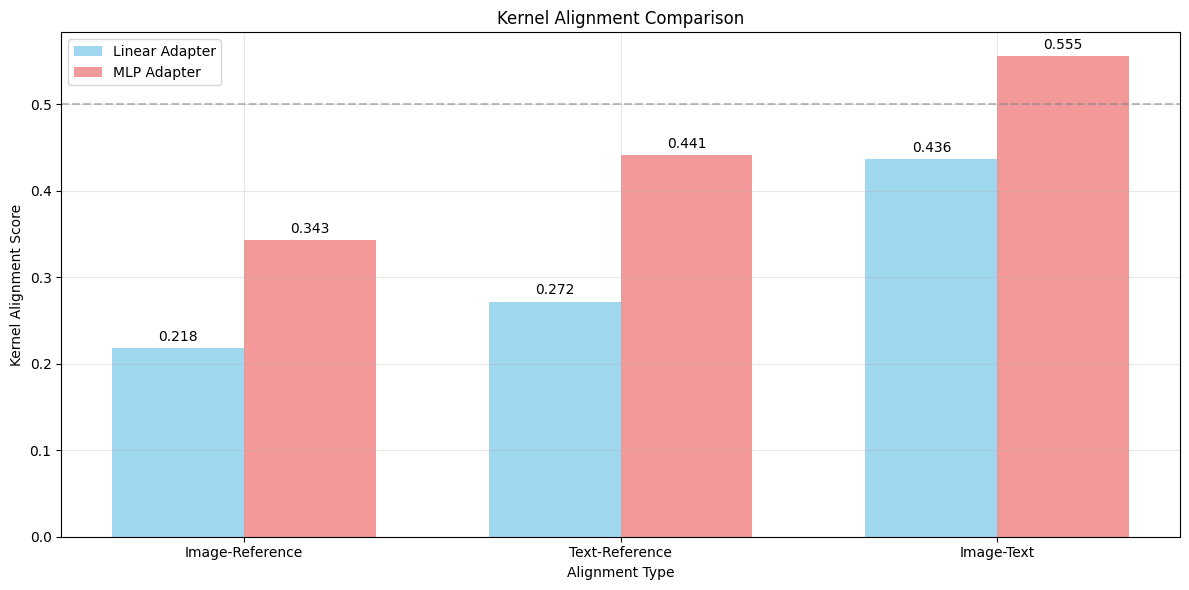


2. Hypothesis Testing Results:


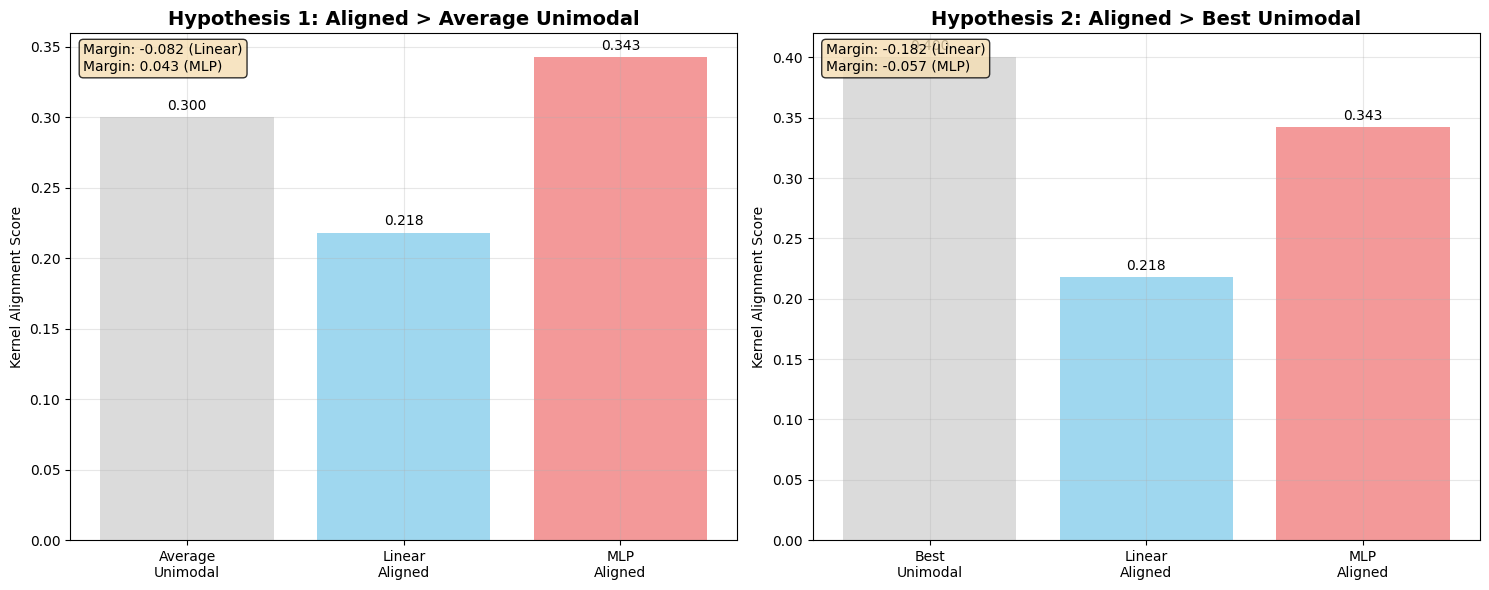


3. Aligned Embeddings MDS Projection:


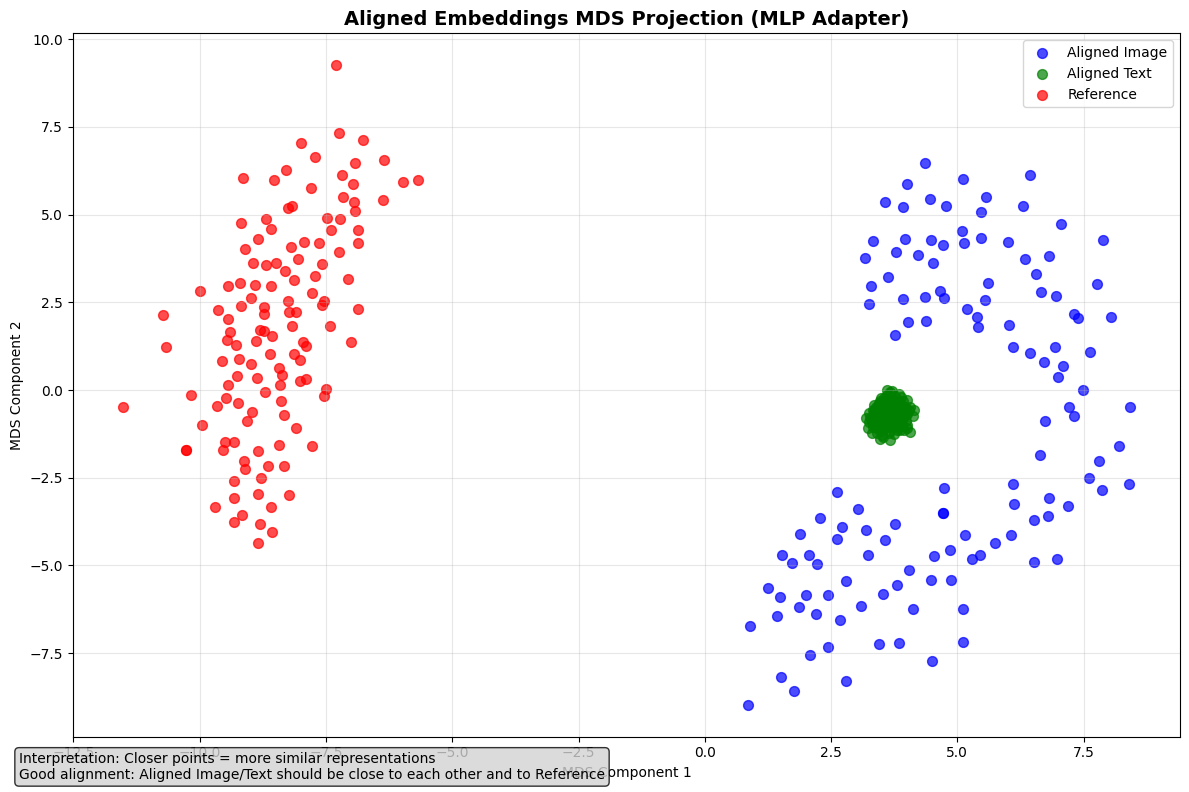


4. Downstream Evaluation Results:
No downstream results available for Linear adapter
No downstream results available for MLP adapter



In [42]:
# Results Analysis (FIXED - No Premature Commentary)
print("="*80)
print("COMPREHENSIVE RESULTS ANALYSIS")
print("="*80)

# Generate comprehensive visualizations
print("\n1. Kernel Alignment Comparison:")
plot_alignment_comparison(linear_metrics, mlp_metrics)

print("\n2. Hypothesis Testing Results:")
plot_hypothesis_tests(linear_metrics, mlp_metrics)

print("\n3. Aligned Embeddings MDS Projection:")
try:
    aligned_img_emb_mlp, aligned_txt_emb_mlp, ref_emb_mlp = extract_embeddings(
        image_encoder, text_encoder, mlp_img_adapter, mlp_txt_adapter,
        reference_encoder, dataloader, config.device, max_samples=100
    )
    
    plot_multimodal_mds(
        aligned_img_emb_mlp, aligned_txt_emb_mlp, ref_emb_mlp,
        title="Aligned Embeddings MDS Projection (MLP Adapter)"
    )
except Exception as e:
    print(f"Could not generate MDS plot: {e}")

print("\n4. Downstream Evaluation Results:")
# Plot downstream results if available
if 'downstream_results' in linear_metrics and linear_metrics['downstream_results'] is not None:
    plot_downstream_results(linear_metrics['downstream_results'], 
                           "Linear Adapter Downstream Results")
else:
    print("No downstream results available for Linear adapter")

if 'downstream_results' in mlp_metrics and mlp_metrics['downstream_results'] is not None:
    plot_downstream_results(mlp_metrics['downstream_results'], 
                           "MLP Adapter Downstream Results")
else:
    print("No downstream results available for MLP adapter")

print("\n" + "="*80)